# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

In [1]:
# this code is for an elaine problem:
import sys
sys.path.append('/Users/elainecunha/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages')

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

### Generate Data

In [3]:
number_of_points = 50
x_train, y_train, x_test = utils.generate_data(number_of_points)

### Define NLM Hyperparameters

In [9]:
# relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


# neural network model design choices
width = 50
hidden_layers = 2
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}


# bayesian linear regression hyperparameters
prior_var = 1.0
y_var = 1.0


# training parameters
params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1,
          'optimizer':'adam'}

### Train NLM

In [10]:
# train NLMs
reg_params = [0.0, 1.0]
nlms = []

for i,r in enumerate(reg_params):

    # append model to list of NLMs
    nlms.append(NLM(prior_var, y_var, r, architecture, random_state = np.random.RandomState(0)))
    
    # train model
    t0 = time.time()
    nlms[i].train(x_train, y_train, params)
    nlm_time = np.round(time.time() - t0, 3)
    
    print('Model {}: {} seconds'.format(i, nlm_time))

 Iteration 9900 lower bound 9.270832092357395; gradient mag: 12.1475750937599836
Done Training
Model 0: 803.452 seconds
 Iteration 9900 lower bound 26.67810667031643; gradient mag: 4.34401643524107784
Done Training
Model 1: 794.513 seconds


### Calculate Posterior and Prior Predictives

In [11]:
# calculate posterior and prior predictives
post_pred_mean = []
post_pred_upper = []
post_pred_lower = []
prior_predictive_samples = []

for model in nlms:
    
    # get posterior and prior samples
    post_pred, post_pred_samples = model.predict(x_test, prior=False)
    prior_pred, prior_pred_samples = model.predict(x_test, prior=True)

    # calculate posterior predictive mean
    pp_mean = np.mean(post_pred_samples, axis=0)
    pp_upper = np.percentile(post_pred_samples, 97.5, axis=0)
    pp_lower = np.percentile(post_pred_samples, 2.5, axis=0)

    # store results
    post_pred_mean.append(pp_mean)
    post_pred_upper.append(pp_upper)
    post_pred_lower.append(pp_lower)
    prior_predictive_samples.append(prior_pred_samples)

### Plot Results

In [12]:
# calculate ground truth line
f = lambda x: (x**3)/2
x_true = np.linspace(-10, 10, 100)
y_true = f(x_true)

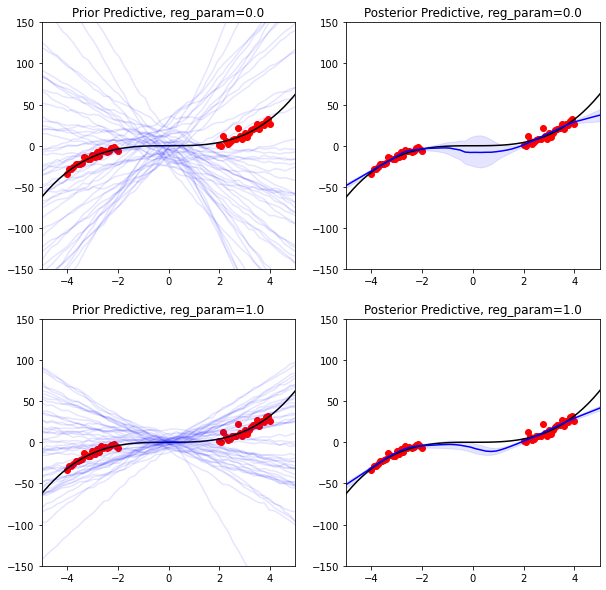

In [13]:
# plot

num_figures = len(nlms)

fig,ax = plt.subplots(num_figures, 2, figsize=(10,10))

for i,model in enumerate(nlms):
    ax[i][0].scatter(x_train, y_train, color='red')
    ax[i][1].scatter(x_train, y_train, color='red')
    ax[i][0].plot(x_true, y_true, color='black')
    ax[i][1].plot(x_true, y_true, color='black')
    ax[i][1].plot(x_test.flatten(), post_pred_mean[i], color='blue')
    ax[i][1].fill_between(x_test.flatten(), post_pred_upper[i], post_pred_lower[i], color='blue', alpha=0.1, label='95% Pred. Interval') 

    for j in range(prior_predictive_samples[i].shape[1]):
        
        ax[i][0].plot(x_test.flatten(), prior_predictive_samples[i][j,:], alpha = 0.1, color='blue')

    ax[i][0].axis([-5, 5, -150, 150])
    ax[i][1].axis([-5, 5, -150, 150])
    ax[i][0].set_title('Prior Predictive, reg_param={}'.format(reg_params[i]))
    ax[i][1].set_title('Posterior Predictive, reg_param={}'.format(reg_params[i]))

plt.show()